### Identify Research Payment V.S. General Payment based on Medical Transaction features
The purpose of this analysis is to build a model to identify medical payment types <br>
This tesk is an aggregated workflow to build a ml process, more like in real cases <br>

The analysis including 3 parts <br>
#### 1. Understand features and select/create features
- drop features with too many missing value, taken into consideration as missing are not correlated to the final result
- winsorize / normalize variables, to avoid 
  - 1. curse of dimension when transforming categorical variable to lables 
  - 2. impact of outlier to the model, by transform the variable into normal distribution
- check data leakage, some of the feature have totally different value for Research payment v.s. General Payment. Understand how those 2 share similar features is critical to avoid data leakage

#### 2. Building model and train/select
- baseline model as tree and logistic regression to understand how features contribute to the result by looking at baseline model coefficients
- refine model by 
  - 1. grouping descriptions with regular expression to reduce dimension
  - 2. spliting some field that could be the combination of multiple dimensions
  - 3. try to find patterns in street/zip <br>
<b> select the model by <br>
  - 4. hyper parameter tuning with cross validation and random search
  - 5. ensemble (RF, Voting, XGBoosting)
    
#### 3. Findings
- amount of payment and location are the most important feature, especially if it is of higher amount and if in U.S. the probability for research funding is high
- also whether the payment is covered by insurance (covered by insurance indicate it is a general payment)
- what is payment method (cash indicate it is a general payment)
- what is the area of treatment, as the research fund is not similarly distributed as the general medical spend - for Oncology the payment is more likely to be research
- other reasons including devices, and code number for cases

#### 4. Result
- the predicted result 95% accuracy for testing set with runed tree, and 98 with XGB model


### Step 3. Modeling

1. fill missing as 'NA'

In [ ]:
comb_reg=comb.copy()[var_2]
comb_reg.fillna('NA',inplace=True)
X_trainval,X_test,y_trainval,y_test=train_test_split(comb_reg,comb['Tag'])
X_train,X_val,y_train,y_val=train_test_split(X_trainval,y_trainval)

cat=comb_reg.dtypes=='object'
cont=comb_reg.dtypes!='object'

prep = ColumnTransformer([("OneHot", OneHotEncoder(handle_unknown='ignore'),cat), ('pt', 'passthrough',cont)])

log = Pipeline([('preprocessing', prep), ('LogReg',LogisticRegression())])

log.fit(X_train,y_train)

#LogReg seems to have a fair result. Check the actual parameter for the model -- which variable plays a more important role
 

log.score(X_train,y_train)

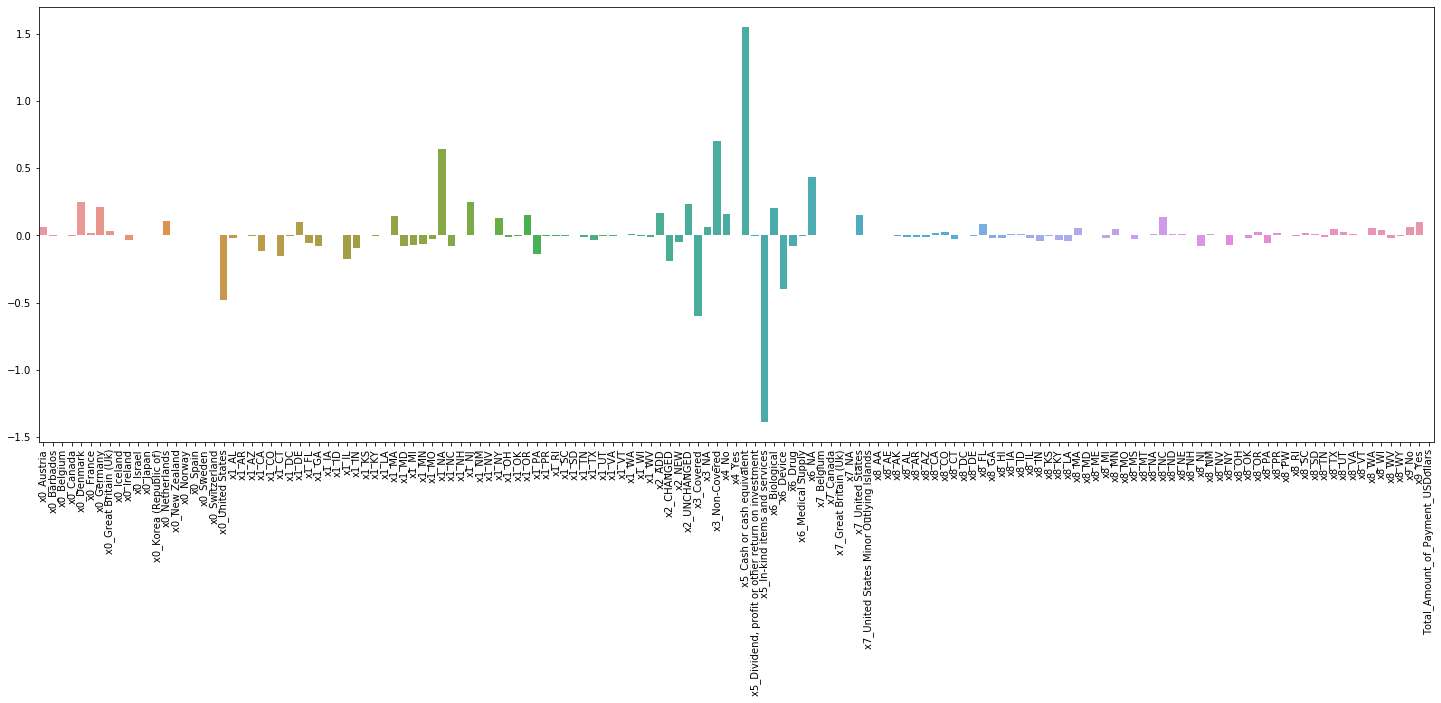

In [81]:
cols = log.named_steps['preprocessing'].named_transformers_['OneHot'].get_feature_names().tolist() \
+ ['Total_Amount_of_Payment_USDollars']
fig, ax = plt.subplots(1, 1, figsize=(25, 8))
plt.xticks(rotation='vertical')
sns.barplot(x=cols, y=log.named_steps['LogReg'].coef_[0])
plt.show()

In [ ]:
# second model is tree

In [82]:
tree = Pipeline([('preprocessing', prep), ('Tree',DecisionTreeClassifier( 
                                        min_impurity_decrease=0.03,
                                     
                                        min_samples_leaf=400, min_samples_split=400,
                                        min_weight_fraction_leaf=0.01,))])

tree.fit(X_train,y_train)

print("{0} training accuracy: {1:.3f} and test accuracy: {2:.3f}".\
      format('tree',\
              tree.score(X_train,y_train),tree.score(X_test,y_test)))

tree_dot = export_graphviz(tree.named_steps['Tree'], out_file=None, feature_names=cols)
graph = graphviz.Source(tree_dot)
graph.render(cleanup=True)
graph

tree training accuracy: 0.878 and test accuracy: 0.877


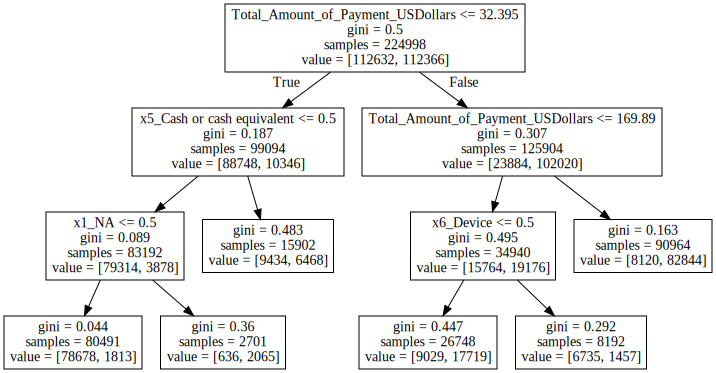

In [88]:
tree = Pipeline([('preprocessing', prep), ('Tree',DecisionTreeClassifier( 
                                        min_impurity_decrease=0.01,
                                     
                                        min_samples_leaf=20, min_samples_split=40,
                                        min_weight_fraction_leaf=0.0001,))])

tree.fit(X_train,y_train)

print("{0} training accuracy: {1:.3f} and test accuracy: {2:.3f}".\
      format('tree',\
              tree.score(X_train,y_train),tree.score(X_test,y_test)))

tree_dot = export_graphviz(tree.named_steps['Tree'], out_file=None, feature_names=cols)
graph = graphviz.Source(tree_dot)
graph.render(cleanup=True)
graph

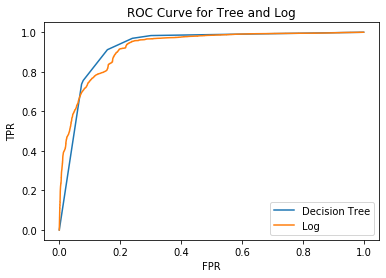

In [89]:
fpr_log, tpr_log, thresholds_log = roc_curve(y_test, log.predict_proba(X_test)[:,1])
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test, tree.predict_proba(X_test)[:,1])
plt.plot(fpr_tree, tpr_tree, label = 'Decision Tree')
plt.plot(fpr_log, tpr_log, label = 'Log')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve for Tree and Log")
plt.legend()
plt.show()

### Step 4 Refining the variables
1. those vars that dropped due to so many categories, check whether we can aggregate them
2. for string var, use NLP to check 

In [93]:
comb_reg.reset_index(inplace=True)
comb_reg.drop('index',axis=1,inplace=True)

ValueError: cannot insert level_0, already exists

In [95]:
comb_reg.columns

Index(['level_0', 'index',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
       'Change_Type', 'Covered_or_Noncovered_Indicator_1',
       'Dispute_Status_for_Publication',
       'Form_of_Payment_or_Transfer_of_Value',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
       'Recipient_Country', 'Recipient_State', 'Related_Product_Indicator',
       'Total_Amount_of_Payment_USDollars'],
      dtype='object')

In [27]:
top_cat("Associated_Drug_or_Biological_NDC_1")

gen
50458-580-30    4988
0169-4060-90    4756
00031-062-10    3789
0078-0659-20    3189
50458-140-30    2724
55513-710-01    2724
0002-1433-80    2294
0006-0277-82    2244
00597-0152-0    2229
0074-4339-02    2157
Name: Associated_Drug_or_Biological_NDC_1, dtype: int64
res
0006-3029-01    9568
62856-529-60    8493
64406-006-02    3538
0597-0140-30    2782
0169-2660-15    2732
65757-300-01    2109
0597-0152-30    1920
0069-0187-21    1788
0024-5901-00    1755
62856-710-30    1645
Name: Associated_Drug_or_Biological_NDC_1, dtype: int64
In common
0


In [17]:
#break them down and check the pattern
s=[]
for  i in comb[ "Associated_Drug_or_Biological_NDC_1"].fillna('0-0-0'): 
    s.append(i.split('-'))
NDC_1_DF=pd.DataFrame(s,columns=['dig1','dig2','dig3'])              

In [102]:
comb_modify=pd.concat([comb_reg,NDC_1_DF],axis=1)

In [18]:
for i in ['dig1','dig2','dig3']: 
    l=comb_modify[i].value_counts()[:10].index.tolist()
    comb_modify[i] = np.where([i in l for i in comb_modify[i]], comb_modify[i],'0')

for this variable, we want to break down into 3 digits and leave the top 10 unchanged for each one

check Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID  and leave top 10 category

In [103]:
l=comb.Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID.value_counts()[:20]

l.index

[i in l.index for i in comb['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID'] ]

comb_modify['Applicable_Manufacturer_or_Applicable_GPO_M']=\
np.where([i in l.index for i in comb['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID'] ],\
         comb['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID'],'000000000000')

CHECK DATE OF PAYMENT

In [104]:
comb_modify['Payment_Weekday']=\
pd.to_datetime(comb['Date_of_Payment']).apply(lambda x:str(x.weekday())).tolist()

In [105]:
comb_modify['Payment_Month']=\
pd.to_datetime(comb['Date_of_Payment']).apply(lambda x:str(x.month)).tolist()

Check name of drug

In [153]:
comb['Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1'].value_counts()

KEYTRUDA                             9995
Belviq                               8641
Victoza                              5820
XARELTO                              5621
JARDIANCE                            4614
                                     ... 
Oryx and Lotus                          1
Provox Laryngectomy Pulmonary Kit       1
SELF-CATH                               1
SHIFT                                   1
RECOMBIVAX HIB                          1
Name: Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1, Length: 5026, dtype: int64

In [154]:
top_cat('Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1')

gen
XARELTO      4998
Victoza      4756
FARXIGA      3789
ENTRESTO     3184
ELIQUIS      3047
JARDIANCE    2751
INVOKANA     2730
Prolia       2724
TRULICITY    2294
JANUVIA      2244
Name: Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1, dtype: int64
res
KEYTRUDA               9568
Belviq                 8493
TECFIDERA              3538
TRADJENTA              2782
Tresiba                2732
Non-Covered Product    2487
Sentus                 2232
Vivitrol 380mg         2109
SAR231893              1888
JARDIANCE              1863
Name: Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1, dtype: int64
In common
1


This the type of drug associated with the payment, <br>
Standardize the format and try to extract key element

In [106]:
conv=comb['Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1'].apply(lambda x:str(x).lower())#.value_counts()

conv=comb['Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1'].apply(lambda x:str(x).lower())
l=conv.value_counts()[:20]

comb_modify['Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1_M']=\
np.where([i in l.index for i in conv],conv,'Other')

check 'Product_Category_or_Therapeutic_Area_1'

In [163]:
top_cat("Product_Category_or_Therapeutic_Area_1")

gen
Diabetes                         10319
RESPIRATORY                       9065
Cardiovascular & Metabolism       7788
Immunology                        6023
CARDIOVASCULAR                    5875
NEUROSCIENCE                      5375
Endocrinology                     5060
Cardiovascular and Metabolism     4865
GASTROENTEROLOGY                  4661
Oncology                          4316
Name: Product_Category_or_Therapeutic_Area_1, dtype: int64
res
ONCOLOGY                        18090
Nutrition and Weight Loss        8493
Oncology                         7688
DIABETES                         7604
Diabetes                         6485
Cardiology/Vascular Diseases     5975
NEUROLOGY                        5788
Immunology                       3878
CNS                              3803
CARDIOVASCULAR                   3596
Name: Product_Category_or_Therapeutic_Area_1, dtype: int64
In common
4


In [107]:
conv=comb['Product_Category_or_Therapeutic_Area_1'].apply(lambda x:str(x).lower())
l=conv.value_counts()[:20]

comb_modify['Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1_M']=\
np.where([i in l.index for i in conv],conv,'Other')

check Therapeutic Area

In [109]:
comb_modify['Product_Category']=comb['Product_Category_or_Therapeutic_Area_1'].apply(lambda x:str(x).lower()).tolist()

In [110]:
comb_modify['Product_Category'] = np.where(comb_modify['Product_Category'].str.contains('resp', regex=True), 'resp', comb_modify['Product_Category'])

comb_modify['Product_Category'] = np.where(comb_modify['Product_Category'].str.contains('diab', regex=True), 'diab', comb_modify['Product_Category'])

comb_modify['Product_Category'] = np.where(comb_modify['Product_Category'].str.contains('oncol', regex=True), 'oncol', comb_modify['Product_Category'])

comb_modify['Product_Category'] = np.where(comb_modify['Product_Category'].str.contains('cardio', regex=True), 'cardio', comb_modify['Product_Category'])

comb_modify['Product_Category'] = np.where(comb_modify['Product_Category'].str.contains('nero', regex=True), 'nero', comb_modify['Product_Category'])

comb_modify['Product_Category'] = np.where(comb_modify['Product_Category'].str.contains('immun', regex=True), 'immun', comb_modify['Product_Category'])

comb_modify['Product_Category'] = np.where(comb_modify['Product_Category'].str.contains('gastro', regex=True), 'gastro', comb_modify['Product_Category'])

comb_modify['Product_Category'] = np.where(comb_modify['Product_Category'].str.contains\
                                           ('resp|diab|oncol|cardio|nero|immun|gastro', regex=True), comb_modify['Product_Category'], 'other')


In [111]:
comb_modify['Product_Category'].value_counts()

other     252194
cardio     40909
oncol      38574
diab       29288
resp       16542
immun      14425
gastro      8066
Name: Product_Category, dtype: int64

In [176]:
top_cat('Recipient_Primary_Business_Street_Address_Line1')

gen
9500 EUCLID AVE            226
11100 EUCLID AVE           175
2500 N STATE ST            161
200 1ST ST SW              139
5323 HARRY HINES BLVD      128
10666 N TORREY PINES RD    124
100 E LANCASTER AVE        122
3800 RESERVOIR RD NW       114
6550 FANNIN ST             103
3400 SPRUCE ST              95
Name: Recipient_Primary_Business_Street_Address_Line1, dtype: int64
res
1 Triangle Dr                1838
12221 MERIT DR STE 500        920
619 SOUTH 19TH STREET         808
1515 HOLCOMBE BLVD            738
2301 COMMONWEALTH BLVD        532
450 BROOKLINE AVE             505
175 CROSS KEYS ROAD           477
11818 WILSHIRE BLVD           461
1211 MEDICAL CENTER DRIVE     440
3730 S EASTERN AVE            429
Name: Recipient_Primary_Business_Street_Address_Line1, dtype: int64
In common
0


the address field is hard to extract any information

In [177]:
top_cat('Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name')

gen
Janssen Pharmaceuticals, Inc                  11108
Pfizer Inc.                                   10609
Allergan Inc.                                  9052
AstraZeneca Pharmaceuticals LP                 8224
Novo Nordisk Inc                               7504
Merck Sharp & Dohme Corporation                6763
Amgen Inc.                                     6076
Novartis Pharmaceuticals Corporation           5970
GlaxoSmithKline, LLC.                          5838
Boehringer Ingelheim Pharmaceuticals, Inc.     5687
Name: Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name, dtype: int64
res
Pfizer Inc.                                   15205
Merck Sharp & Dohme Corporation               13370
Incyte Corporation                            12030
Eisai Inc.                                    10933
Sanofi and Genzyme US Companies               10713
Boehringer Ingelheim Corporate Center GmbH     9723
Alkermes, Inc.                                 8919
AbbVie, Inc.                  

In [112]:
GPO=comb['Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name'].fillna('NA').apply(lambda x: x.lower().split(' ')[0])

L=GPO.value_counts()[:10].index

comb_modify['GPO_M']=[i if i in L else 'other' for i in GPO ]

comb_modify['GPO_M'].value_counts()

other          241971
pfizer          25655
merck           20426
sanofi          16674
boehringer      16564
janssen         16563
novo            14274
abbvie,         13110
incyte          12231
astrazeneca     11420
eisai           11110
Name: GPO_M, dtype: int64